# WiDS Datathon - Diabetes Mellitus 

In [ ]:
import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import ast
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

## Load data

In [ ]:
# read train and test data
train = pd.read_csv(r'TrainingWiDS2021.csv', index_col= 'Unnamed: 0')
test = pd.read_csv(r'UnlabeledWiDS2021.csv', index_col= 'Unnamed: 0')
# reset to default index to avoid confusion
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

## Load Data Dictionary

In [ ]:
data_dictionary = pd.read_csv(r'DataDictionaryWiDS2021.csv')

In [ ]:
data_dictionary.head(20)
print(data_dictionary['Data Type'].unique())        

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,demographic,age,Years,numeric,The age of the patient on unit admission,None
3,demographic,bmi,kilograms/metres^2,string,The body mass index of the person on unit admi...,21.5
4,demographic,elective_surgery,None,binary,Whether the patient was admitted to the hospit...,0
5,demographic,ethnicity,None,string,The common national or cultural tradition whic...,Caucasian
6,demographic,gender,None,string,The genotypical sex of the patient,F
7,demographic,height,centimetres,numeric,The height of the person on unit admission,180
8,demographic,hospital_admit_source,None,string,The location of the patient prior to being adm...,Home
9,demographic,icu_admit_source,None,string,The location of the patient prior to being adm...,Operating room


['integer' 'numeric' 'string' 'binary']


In [ ]:
data_dictionary

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,demographic,age,Years,numeric,The age of the patient on unit admission,None
3,demographic,bmi,kilograms/metres^2,string,The body mass index of the person on unit admi...,21.5
4,demographic,elective_surgery,None,binary,Whether the patient was admitted to the hospit...,0
...,...,...,...,...,...,...
176,APACHE comorbidity,immunosuppression,None,binary,Whether the patient has their immune system su...,1
177,APACHE comorbidity,leukemia,None,binary,Whether the patient has been diagnosed with ac...,1
178,APACHE comorbidity,lymphoma,None,binary,Whether the patient has been diagnosed with no...,1
179,APACHE comorbidity,solid_tumor_with_metastasis,None,binary,Whether the patient has been diagnosed with an...,1


In [ ]:
data_dictionary['Data Type'].unique()

array(['integer', 'numeric', 'string', 'binary'], dtype=object)

In [ ]:
string_columns = data_dictionary.loc[data_dictionary['Data Type'] == 'string', 'Variable Name'].tolist()
print(string_columns)

['bmi', 'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_admit_type', 'icu_stay_type', 'icu_type', 'apache_2_diagnosis', 'apache_3j_diagnosis']


In [ ]:
binary_columns = data_dictionary.loc[data_dictionary['Data Type'] == 'binary', 'Variable Name'].tolist()
print(binary_columns)

['elective_surgery', 'readmission_status', 'apache_post_operative', 'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'diabetes_mellitus']


In [ ]:
numeric_columns = data_dictionary.loc[data_dictionary['Data Type'] == 'numeric', 'Variable Name'].tolist()
#print(numeric_columns)
integer_columns = data_dictionary.loc[data_dictionary['Data Type'] == 'integer', 'Variable Name'].tolist()
#print(integer_columns)
number_columns = numeric_columns + integer_columns
print(number_columns)

['age', 'height', 'pre_icu_los_days', 'weight', 'albumin_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_

In [ ]:
len(number_columns) + len(string_columns) + len(binary_columns)

181

## Basic exploration of train and test data

In [ ]:
train.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,...,337.0,337.0,0,0,0,0,0,0,0,0
4,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0


In [ ]:
#exploration of data number of columns and rows
print('train data shape',train.shape)
print('test data shape',test.shape)

train data shape (130157, 180)
test data shape (10234, 179)


In [ ]:
# column names
print('train columns \n ', train.columns)
print('test columns \n', test.columns)

train columns 
  Index(['encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery',
       'ethnicity', 'gender', 'height', 'hospital_admit_source',
       'icu_admit_source',
       ...
       'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'aids', 'cirrhosis',
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'diabetes_mellitus'],
      dtype='object', length=180)
test columns 
 Index(['encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery',
       'ethnicity', 'gender', 'height', 'hospital_admit_source',
       'icu_admit_source',
       ...
       'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min',
       'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis'],
      dtype='object', length=179)


In [ ]:
# An overview of missing data
train_null = train.columns[train.isnull().any()]
test_null = test.columns[test.isnull().any()]
print('columns with nulls in train \n',train_null)

columns with nulls in train 
 Index(['age', 'bmi', 'ethnicity', 'gender', 'height', 'hospital_admit_source',
       'icu_admit_source', 'weight', 'albumin_apache', 'apache_2_diagnosis',
       ...
       'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max',
       'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min',
       'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max',
       'h1_pao2fio2ratio_min'],
      dtype='object', length=160)


In [ ]:
print('columns with nulls in test \n',test_null)

columns with nulls in test 
 Index(['bmi', 'ethnicity', 'gender', 'height', 'hospital_admit_source',
       'icu_admit_source', 'weight', 'albumin_apache', 'apache_2_diagnosis',
       'apache_3j_diagnosis',
       ...
       'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max',
       'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min',
       'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max',
       'h1_pao2fio2ratio_min'],
      dtype='object', length=159)


In [ ]:
print('train data summary \n',train.describe())
print('test data summary \n',test.describe())

train data summary 
         encounter_id    hospital_id            age            bmi  \
count  130157.000000  130157.000000  125169.000000  125667.000000   
mean   213000.856519     106.102131      61.995103      29.110260   
std     38109.828146      63.482277      16.822880       8.262776   
min    147000.000000       1.000000       0.000000      14.844926   
25%    180001.000000      49.000000      52.000000      23.598006   
50%    213014.000000     112.000000      64.000000      27.564749   
75%    246002.000000     165.000000      75.000000      32.803127   
max    279000.000000     204.000000      89.000000      67.814990   

       elective_surgery         height         icu_id  pre_icu_los_days  \
count     130157.000000  128080.000000  130157.000000     130157.000000   
mean           0.189840     169.607219     662.428344          0.839933   
std            0.392176      10.833085     304.259843          2.485337   
min            0.000000     137.200000      82.000000    

## Exploration of target column

[array([1, 0], dtype=int64)]


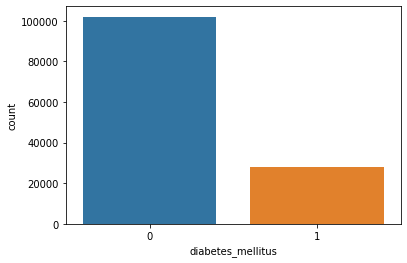

0    102006
1     28151
Name: diabetes_mellitus, dtype: int64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#exploration of target variable 
target_values = [train['diabetes_mellitus'].unique()]
print(target_values)
#the target variable is either 0 or 1, making the data problem a categoric one
sns.countplot(train['diabetes_mellitus'])
plt.show()
#the graph shows that the train data is imbalanced
print(train['diabetes_mellitus'].value_counts())

## Copy train df for Exploratory Analysis

In [ ]:
# making a copy of train df without target column for exploration
_train = train.copy()
_train.shape

(130157, 180)

## Exploration of categorical (string) columns

In [ ]:
string_columns = _train.select_dtypes(include='O')
string_columns

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type
0,Caucasian,M,Floor,Floor,admit,CTICU
1,Caucasian,F,Floor,Floor,admit,Med-Surg ICU
2,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU
3,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU
4,Caucasian,M,NaN,Accident & Emergency,admit,Med-Surg ICU
...,...,...,...,...,...,...
130152,Caucasian,M,Emergency Department,Accident & Emergency,admit,Cardiac ICU
130153,Caucasian,F,Direct Admit,Accident & Emergency,admit,MICU
130154,African American,M,Emergency Department,Accident & Emergency,admit,Cardiac ICU
130155,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU


In [ ]:
# we'll look at the unique values of all the string cols
icu_stay = string_columns['icu_stay_type']
icu_type = string_columns['icu_type']
ethnicity = string_columns['ethnicity']
gender = string_columns['gender']
hospital_admit_source = string_columns['hospital_admit_source']
icu_admit_source = string_columns['icu_admit_source']
for cols in string_columns.columns:
  print('\n {} unique values: {}'.format(cols,string_columns[cols].unique()))


 ethnicity unique values: ['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']

 gender unique values: ['M' 'F' nan]

 hospital_admit_source unique values: ['Floor' 'Emergency Department' 'Operating Room' nan 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other']

 icu_admit_source unique values: ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]

 icu_stay_type unique values: ['admit' 'readmit' 'transfer']

 icu_type unique values: ['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']


In [ ]:
# number of missing values in object dtype cols
print('\n',string_columns.isnull().sum())


 ethnicity                 1587
gender                      66
hospital_admit_source    33198
icu_admit_source           240
icu_stay_type                0
icu_type                     0
dtype: int64


### Handling missing values in string columns

#### Train data

In [ ]:
# We will replace NaN values in ethnicity with 'other/unknown' (makes sense)
_train['ethnicity'] = ethnicity.fillna('Other/Unknown')
string_columns['ethnicity'] = _train['ethnicity']

In [ ]:
# imputing gender with most frequent gender
_train['gender'] = _train['gender'].fillna(_train['gender'].value_counts().index[0])
# since gender has only 66 missing values, the missing values can be removed from the entire dataframe (train)
# _train.dropna(subset=['gender'], inplace=True)
# _train.reset_index(drop=True, inplace=True)
print(_train.shape)
string_columns['gender'] = string_columns['gender'].fillna(string_columns['gender'].value_counts().index[0])
print(string_columns.shape)

(130157, 180)
(130157, 6)


In [ ]:
# check if index is reset
_train

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,...,337.0,337.0,0,0,0,0,0,0,0,0
4,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,164758,7,50.0,29.287256,0,Caucasian,M,175.3,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
130153,197653,7,79.0,29.653433,0,Caucasian,F,162.6,Direct Admit,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
130154,219719,7,73.0,32.265371,0,African American,M,177.8,Emergency Department,Accident & Emergency,...,163.0,163.0,0,0,0,0,0,0,0,1
130155,222562,170,81.0,24.408579,0,Caucasian,M,185.4,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0


In [ ]:
# replace missing values with 'Unknown' for hospital and icu admit source
hospital_admit_source = hospital_admit_source.fillna(value='Unknown')
icu_admit_source = icu_admit_source.fillna(value='Unknown')
string_columns.hospital_admit_source = hospital_admit_source
string_columns.icu_admit_source = icu_admit_source

In [ ]:
_train['hospital_admit_source'] = hospital_admit_source
_train['icu_admit_source'] = icu_admit_source

In [ ]:
# after handling missing values
string_columns.isna().sum()

ethnicity                0
gender                   0
hospital_admit_source    0
icu_admit_source         0
icu_stay_type            0
icu_type                 0
dtype: int64

#### Test data

In [ ]:
test_categorical = test.select_dtypes(include='O')
test_categorical

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type
0,Caucasian,F,Floor,Accident & Emergency,admit,Med-Surg ICU
1,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU
2,Caucasian,F,Floor,Floor,admit,Med-Surg ICU
3,Caucasian,M,Floor,Floor,admit,Med-Surg ICU
4,Caucasian,M,Direct Admit,Accident & Emergency,admit,Med-Surg ICU
...,...,...,...,...,...,...
10229,Caucasian,F,Floor,Floor,admit,Med-Surg ICU
10230,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU
10231,Caucasian,F,Step-Down Unit (SDU),Floor,admit,Med-Surg ICU
10232,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU


In [ ]:
for cols in test_categorical.columns:
  print('\n {} unique values: {}'.format(cols,test_categorical[cols].unique()))


 ethnicity unique values: ['Caucasian' nan 'Hispanic' 'Other/Unknown' 'African American' 'Asian'
 'Native American']

 gender unique values: ['F' 'M' nan]

 hospital_admit_source unique values: ['Floor' 'Emergency Department' 'Direct Admit' nan 'Operating Room'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Step-Down Unit (SDU)' 'Chest Pain Center']

 icu_admit_source unique values: ['Accident & Emergency' 'Floor' 'Operating Room / Recovery'
 'Other Hospital' nan 'Other ICU']

 icu_stay_type unique values: ['admit' 'readmit' 'transfer']

 icu_type unique values: ['Med-Surg ICU' 'SICU' 'CTICU' 'Neuro ICU' 'CCU-CTICU' 'MICU'
 'Cardiac ICU' 'CSICU']


In [ ]:
test_categorical.isna().sum()

ethnicity                 204
gender                      5
hospital_admit_source    2733
icu_admit_source           25
icu_stay_type               0
icu_type                    0
dtype: int64

In [ ]:
# repeating same process as train df categorical features
test['ethnicity'] = test_categorical.ethnicity.fillna('Other/Unknown')
test['hospital_admit_source'] = test_categorical.hospital_admit_source.fillna(value='Unknown')
test['icu_admit_source'] = test_categorical.icu_admit_source.fillna(value='Unknown')
test['gender'] = test['gender'].fillna(test['gender'].value_counts().index[0])
# test.reset_index(drop=True, inplace=True)

In [ ]:
test.select_dtypes(include='O').isna().sum()
test.shape

ethnicity                0
gender                   0
hospital_admit_source    0
icu_admit_source         0
icu_stay_type            0
icu_type                 0
dtype: int64

(10234, 179)

### Visualising categorical features

[Text(0, 0, 'Caucasian'),
 Text(0, 0, 'Other/Unknown'),
 Text(0, 0, 'Hispanic'),
 Text(0, 0, 'African American'),
 Text(0, 0, 'Asian'),
 Text(0, 0, 'Native American')]

[Text(0, 0, 'M'), Text(0, 0, 'F')]

[Text(0, 0, 'Floor'),
 Text(0, 0, 'Emergency Department'),
 Text(0, 0, 'Operating Room'),
 Text(0, 0, 'Unknown'),
 Text(0, 0, 'Direct Admit'),
 Text(0, 0, 'Other Hospital'),
 Text(0, 0, 'Other ICU'),
 Text(0, 0, 'ICU to SDU'),
 Text(0, 0, 'Recovery Room'),
 Text(0, 0, 'Chest Pain Center'),
 Text(0, 0, 'Step-Down Unit (SDU)'),
 Text(0, 0, 'Acute Care/Floor'),
 Text(0, 0, 'PACU'),
 Text(0, 0, 'Observation'),
 Text(0, 0, 'ICU'),
 Text(0, 0, 'Other')]

[Text(0, 0, 'Floor'),
 Text(0, 0, 'Accident & Emergency'),
 Text(0, 0, 'Operating Room / Recovery'),
 Text(0, 0, 'Other Hospital'),
 Text(0, 0, 'Other ICU'),
 Text(0, 0, 'Unknown')]

[Text(0, 0, 'admit'), Text(0, 0, 'readmit'), Text(0, 0, 'transfer')]

[Text(0, 0, 'CTICU'),
 Text(0, 0, 'Med-Surg ICU'),
 Text(0, 0, 'CCU-CTICU'),
 Text(0, 0, 'Neuro ICU'),
 Text(0, 0, 'MICU'),
 Text(0, 0, 'SICU'),
 Text(0, 0, 'Cardiac ICU'),
 Text(0, 0, 'CSICU')]

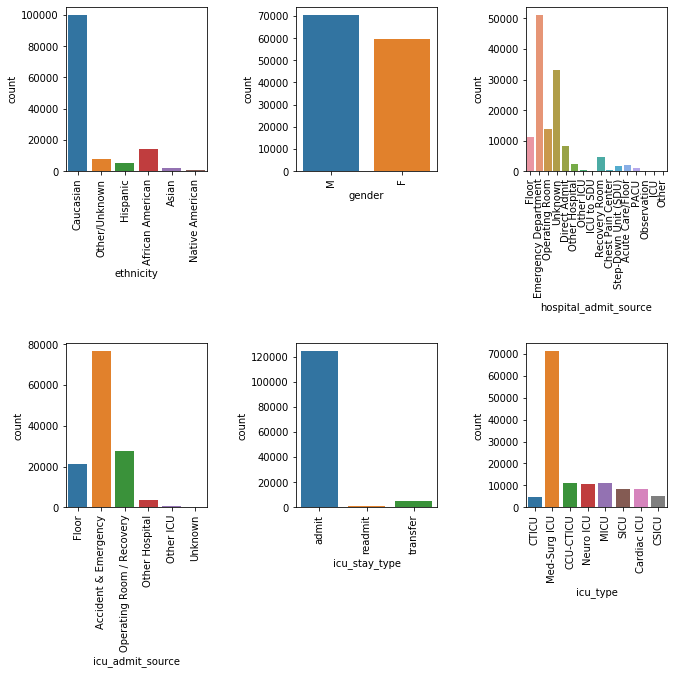

In [ ]:
# Countplots of categorical features
fig, axes = plt.subplots(2,3, figsize = (10,10))
column = 0
row = 0
for i in string_columns.columns:
    while column < 3:
        c = sns.countplot(string_columns[i], ax = axes[column,row])
        c.set_xticklabels(c.get_xticklabels(), rotation=90)
        row = row + 1
        if row >= 3:
            column = column + 1
            row = 0
        break
fig.tight_layout(pad=3.0)
plt.show()

### Encoding categorical to numerical: train and test

In [ ]:
_train.select_dtypes(include='O').isna().sum()

ethnicity                0
gender                   0
hospital_admit_source    0
icu_admit_source         0
icu_stay_type            0
icu_type                 0
dtype: int64

In [ ]:
for c in _train.columns:
    if _train[c].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(_train[c].values) + list(test[c].values))
        _train[c] = lbl.transform(_train[c].values)
        test[c] = lbl.transform(test[c].values)

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

In [ ]:
_train.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,2,1,180.3,4,1,...,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,2,0,160.0,4,1,...,51.0,51.0,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,2,0,172.7,3,0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,2,0,165.1,8,2,...,337.0,337.0,0,0,0,0,0,0,0,0
4,201746,33,19.0,NaN,0,2,1,188.0,15,0,...,NaN,NaN,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,144740,10141,72,NaN,0,2,0,152.4,4,0,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,141990,10141,86,NaN,0,2,0,175.3,3,0,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,142038,10141,72,NaN,0,2,0,162.6,4,1,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,138628,10141,66,NaN,0,2,1,177.8,4,1,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,141682,10141,89,NaN,0,2,1,170.2,2,0,...,NaN,NaN,NaN,0,0,0,0,0,0,0


In [ ]:
_train.columns[_train.isna().any()] # no categorical columns should have null/missing values

Index(['age', 'bmi', 'height', 'weight', 'albumin_apache',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'bilirubin_apache',
       'bun_apache', 'creatinine_apache',
       ...
       'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max',
       'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min',
       'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max',
       'h1_pao2fio2ratio_min'],
      dtype='object', length=156)

## Exploration of numeric columns

In [ ]:
# filtering out columns with numeric dtype 
number_columns = _train.select_dtypes(include=[np.number])
number_columns

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,2,1,180.3,4,1,...,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,2,0,160.0,4,1,...,51.0,51.0,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,2,0,172.7,3,0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,2,0,165.1,8,2,...,337.0,337.0,0,0,0,0,0,0,0,0
4,201746,33,19.0,NaN,0,2,1,188.0,15,0,...,NaN,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,164758,7,50.0,29.287256,0,2,1,175.3,3,0,...,NaN,NaN,0,0,0,0,0,0,0,0
130153,197653,7,79.0,29.653433,0,2,0,162.6,2,0,...,NaN,NaN,0,0,0,0,0,0,0,0
130154,219719,7,73.0,32.265371,0,0,1,177.8,3,0,...,163.0,163.0,0,0,0,0,0,0,0,1
130155,222562,170,81.0,24.408579,0,2,1,185.4,3,0,...,NaN,NaN,0,0,0,0,0,0,0,0


In [ ]:
# removing 'identifier' and 'categorical' columns from number_columns
number_columns = number_columns.drop(columns=['encounter_id', 'hospital_id', 'icu_id', 'ethnicity', 'gender' ,'hospital_admit_source','icu_admit_source','icu_stay_type', 'icu_type'])

In [ ]:
# identify and remove 'binary' dtype columns from number_columns
binary_vals = []
for c in number_columns.columns:
  if sum(number_columns[c].unique()) == 1: 
    print(c)
    binary_vals.append(c)
    number_columns = number_columns.drop(columns = c)
  elif sum(number_columns[c].unique())==0:
    print('0',c)
    binary_vals.append(c)
    number_columns = number_columns.drop(columns = c)

# defining binary cols
binary_cols = _train[binary_vals]

number_columns

elective_surgery
0 readmission_status
apache_post_operative
arf_apache
intubated_apache
ventilated_apache
aids
cirrhosis
hepatic_failure
immunosuppression
leukemia
lymphoma
solid_tumor_with_metastasis
diabetes_mellitus


,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,...,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
0,68.0,22.732803,180.3,0.541667,73.9,2.3,113.0,502.01,0.4,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,77.0,27.421875,160.0,0.927778,70.2,NaN,108.0,203.01,NaN,9.0,...,54.8,51.000000,37.0,37.0,7.450,7.450,51.0,51.0,51.0,51.0
2,25.0,31.952749,172.7,0.000694,95.3,NaN,122.0,703.03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,81.0,22.635548,165.1,0.000694,61.7,NaN,203.0,1206.03,NaN,NaN,...,342.5,236.666667,36.0,33.0,7.370,7.340,337.0,265.0,337.0,337.0
4,19.0,NaN,188.0,0.073611,NaN,NaN,119.0,601.01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,50.0,29.287256,175.3,0.023611,90.0,NaN,110.0,104.01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130153,79.0,29.653433,162.6,0.009722,78.4,3.5,105.0,207.01,0.7,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130154,73.0,32.265371,177.8,0.143056,102.0,NaN,114.0,102.01,NaN,30.0,...,163.0,80.000000,36.9,36.9,7.231,7.231,163.0,163.0,163.0,163.0
130155,81.0,24.408579,185.4,0.188194,83.9,NaN,124.0,306.01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
number_columns.shape

(130157, 157)

In [ ]:
number_columns.describe()

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,...,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
count,125169.000000,125667.000000,128080.000000,130157.000000,126694.000000,51994.000000,128472.000000,129292.000000,47597.000000,104746.000000,...,36818.000000,36818.000000,22491.000000,22491.000000,22308.000000,22308.000000,22712.000000,22712.000000,16760.000000,16760.000000
mean,61.995103,29.110260,169.607219,0.839933,83.791104,2.886149,185.492683,565.994296,1.201222,25.718070,...,287.600071,224.005403,44.552966,43.341081,7.337283,7.327771,163.035835,145.949537,247.525419,239.617358
std,16.822880,8.262776,10.833085,2.485337,24.963063,0.689812,85.858208,466.510850,2.351994,20.690041,...,130.319620,119.119675,14.631359,14.052015,0.105930,0.108658,112.646743,100.211935,131.440167,128.562211
min,0.000000,14.844926,137.200000,-0.250000,38.600000,1.200000,101.000000,0.010000,0.100000,4.000000,...,54.800000,36.000000,15.000000,14.997000,6.930000,6.900000,34.000000,31.000000,42.000000,38.000000
25%,52.000000,23.598006,162.500000,0.045833,66.500000,2.400000,113.000000,204.010000,0.400000,13.000000,...,192.205556,132.000000,36.000000,35.000000,7.290000,7.280000,80.000000,77.000000,144.000000,138.000000
50%,64.000000,27.564749,170.100000,0.155556,80.000000,2.900000,122.000000,409.020000,0.700000,19.000000,...,275.000000,205.000000,42.000000,41.000000,7.350000,7.340000,119.900000,108.000000,228.125000,218.750000
75%,75.000000,32.803127,177.800000,0.423611,96.800000,3.400000,301.000000,703.030000,1.100000,31.000000,...,370.000000,300.000000,49.000000,48.000000,7.408000,7.400000,214.000000,182.000000,333.000000,324.000000
max,89.000000,67.814990,195.590000,175.627778,186.000000,4.600000,308.000000,2201.050000,60.200000,127.000000,...,834.805000,604.227778,111.505000,107.000000,7.570000,7.563000,534.905000,514.905000,720.000000,654.813793


### Visualising numerical features: histogram

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176801D3188>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176801A4608>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768016BF88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B651C48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B68F748>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B6BCF48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B6F28C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B722F88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B75B708>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B791488>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B7C9148>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B7F9DC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B82FA88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B867748>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B89D448>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001768B8D3148>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698525D48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769855CA08>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698592708>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176985CA3C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176985F9FC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698631D48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176986679C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769869D988>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176986D2B88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698708DC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769873DFC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176987431C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176987AB408>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176987E3608>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698818808>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769884CA48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698882BC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176988B7DC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176988EEF88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698928248>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769895E448>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769895D608>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176989C9808>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176989FCA08>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698A31C08>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698A65E48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698A9AF88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698AD6248>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698B0C488>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698B41688>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698B77888>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698BADA48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698BD3B48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698C06D48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698C3CF88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698C761C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698CAC3C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698CDF588>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698D15788>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698D4D988>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698D83BC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698DB6DC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698DEBF88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698DEE248>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698E59448>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698E8F648>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698EC6888>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698EC59C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698F31BC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698F66DC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698F9CF88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017698FD0248>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699007448>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769903D648>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699074848>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176990AAA48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176990E1C88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699115E88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769914BFC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176991812C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176991B64C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176991EC6C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699222908>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699256A88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769928BC88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176992C4EC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176992FB108>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699331308>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176993664C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769939C6C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176993D38C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699407AC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769943DD08>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699473EC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176994AA108>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176994E0348>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699514548>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699548748>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769957F908>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176995B6B08>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176995EBD08>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699623F48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699659188>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769968F388>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176996C5588>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176996FA788>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699730988>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699766BC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769979ADC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176997CEF88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699807208>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769983D408>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699873608>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176998A9848>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176998DE9C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699913BC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769994ADC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699980F88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176999B8248>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000176999ED408>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699A22648>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699A58848>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699A8DA48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699AC2C88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699AF8E08>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699B2EF88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699B65288>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699B9A488>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699BD1688>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699C07848>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699C3D9C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699C72BC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699CA9E08>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699CDFF88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699D15248>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699D4A408>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699D7F608>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699DB6808>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699DEBA48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699E21C48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699E57E08>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699E8EFC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699EC3288>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699EF9488>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699F2F6C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699F65848>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699F9BA48>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017699FD2C88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769A006E88>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769A03D048>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769A0722C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769A0A84C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769A0DE6C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769A1138C8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769A149B08>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769A180D08>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769A1B6EC8>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769A1EC148>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769A222348>],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001769A258548>],
      dtype=object)

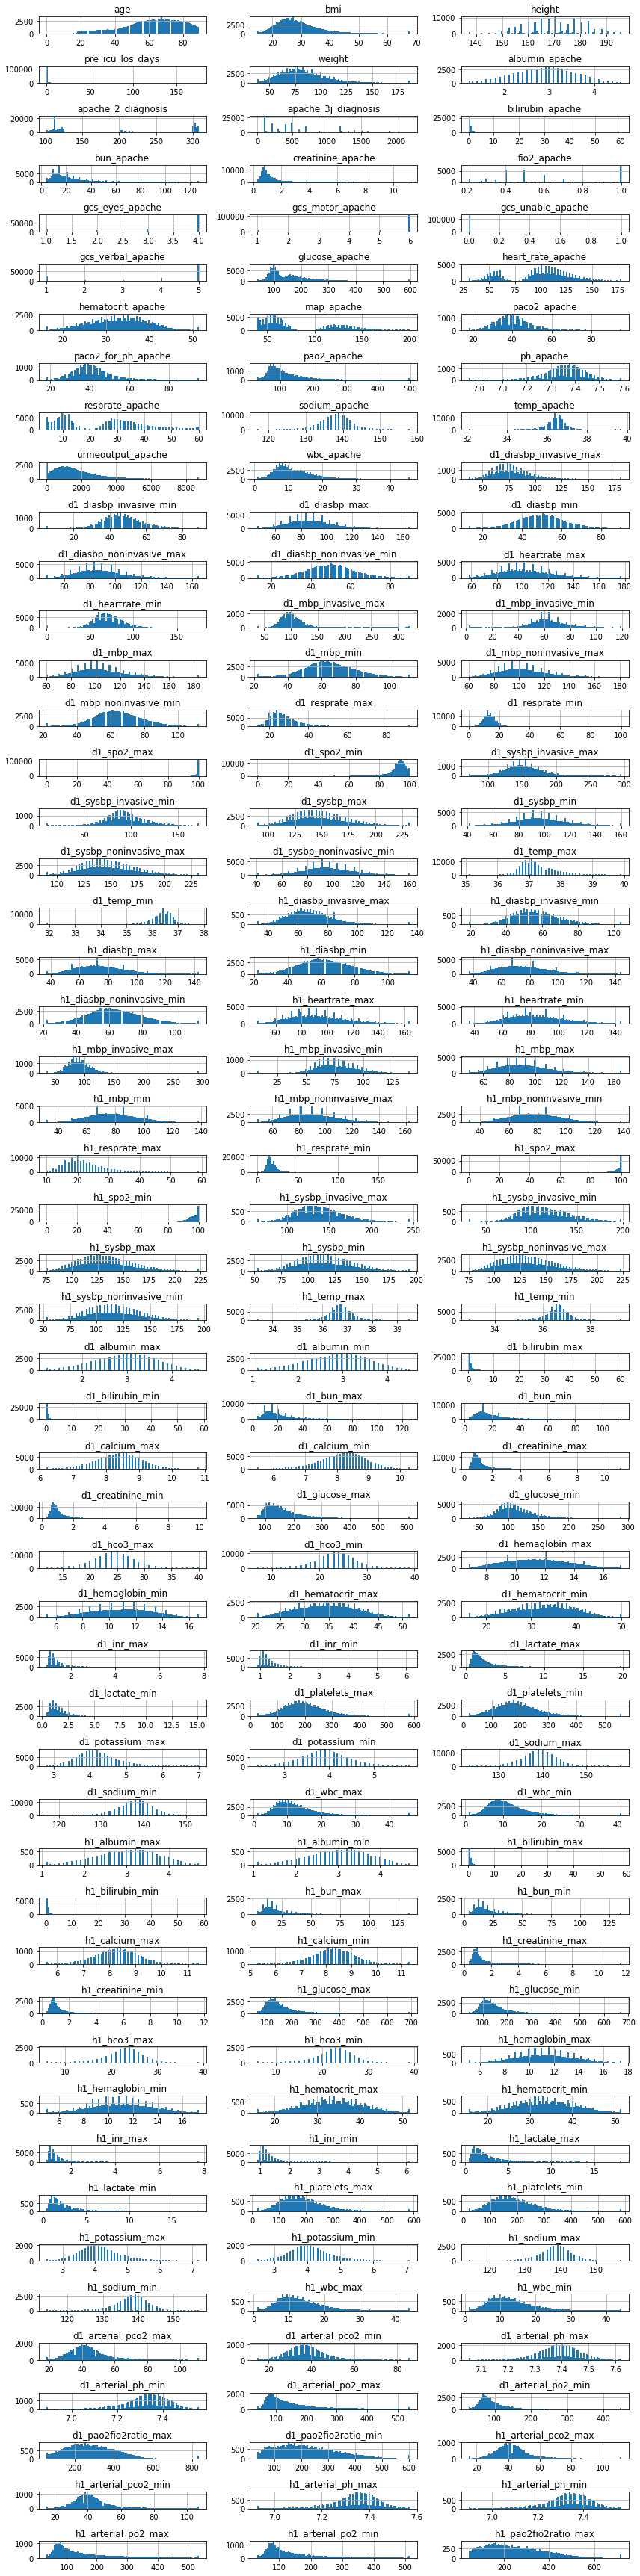

In [ ]:
# hist to view distributions
fig, ax = plt.subplots(len(number_columns.columns)//3, 3, figsize=(12, 48))
axes = ax.flatten()
for col, axis in zip(number_columns.columns, axes):
    number_columns.hist(column = col, bins = 100, ax=axis)
plt.tight_layout()
    

### Boxplot


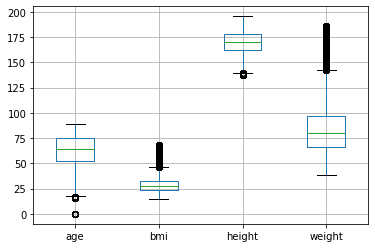

In [ ]:
number_columns.boxplot(column=['age','bmi','height','weight'])

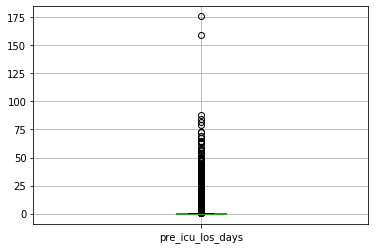

In [ ]:
# has lot of outliers
number_columns.boxplot(column='pre_icu_los_days')

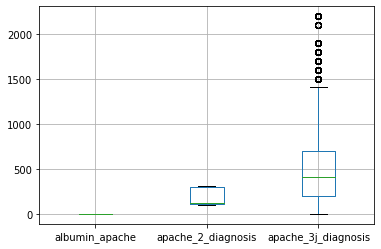

In [ ]:
number_columns.boxplot(column=list(number_columns.columns[5:8]))

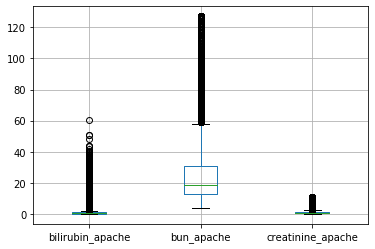

In [ ]:
number_columns.boxplot(column=list(number_columns.columns[8:11]))

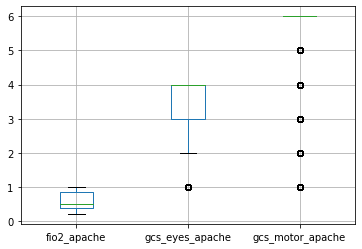

In [ ]:
number_columns.boxplot(column=list(number_columns.columns[11:14]))

### HANDLING NULL VALUES: Numeric columns

In [ ]:
# to find integer columns with null values and check the percentage of null values
count_of_columns = 0
# a = np.array([50,60,70,80,90,100])
percent_NA = 0
for i in _train.columns:
    if _train[i].dtype != 'O':
        percent_NA = round(100*(_train[i].isnull().sum()/len(_train.index)),2)     
    # Replace app2 with relevant name
    ##if percent_NA >= 60:
        print(i, 'has ', percent_NA, ' % null values')
        #train = train.drop(columns=i)
        count_of_columns += 1

print(count_of_columns)

encounter_id has  0.0  % null values
hospital_id has  0.0  % null values
age has  3.83  % null values
bmi has  3.45  % null values
elective_surgery has  0.0  % null values
ethnicity has  0.0  % null values
gender has  0.0  % null values
height has  1.6  % null values
hospital_admit_source has  0.0  % null values
icu_admit_source has  0.0  % null values
icu_id has  0.0  % null values
icu_stay_type has  0.0  % null values
icu_type has  0.0  % null values
pre_icu_los_days has  0.0  % null values
readmission_status has  0.0  % null values
weight has  2.66  % null values
albumin_apache has  60.05  % null values
apache_2_diagnosis has  1.29  % null values
apache_3j_diagnosis has  0.66  % null values
apache_post_operative has  0.0  % null values
arf_apache has  0.0  % null values
bilirubin_apache has  63.43  % null values
bun_apache has  19.52  % null values
creatinine_apache has  19.12  % null values
fio2_apache has  76.62  % null values
gcs_eyes_apache has  1.68  % null values
gcs_motor_apa

In [ ]:
# getting rid of columns with more than 60% of null values
count_of_columns_removed = 0
# a = np.array([50,60,70,80,90,100])
percent_NA = 0
for i in number_columns.columns:
    percent_NA = round(100*(_train[i].isnull().sum()/len(_train.index)),2)     
    # Replace app2 with relevant name
    if percent_NA >= 60:
        print(i)
        # drop columns in both _train and number_columns to avoid confusion
        _train = _train.drop(columns=i)
        number_columns = number_columns.drop(columns=i)
        count_of_columns_removed += 1

print(count_of_columns_removed)

albumin_apache
bilirubin_apache
fio2_apache
paco2_apache
paco2_for_ph_apache
pao2_apache
ph_apache
d1_diasbp_invasive_max
d1_diasbp_invasive_min
d1_mbp_invasive_max
d1_mbp_invasive_min
d1_sysbp_invasive_max
d1_sysbp_invasive_min
h1_diasbp_invasive_max
h1_diasbp_invasive_min
h1_mbp_invasive_max
h1_mbp_invasive_min
h1_sysbp_invasive_max
h1_sysbp_invasive_min
d1_inr_max
d1_inr_min
d1_lactate_max
d1_lactate_min
h1_albumin_max
h1_albumin_min
h1_bilirubin_max
h1_bilirubin_min
h1_bun_max
h1_bun_min
h1_calcium_max
h1_calcium_min
h1_creatinine_max
h1_creatinine_min
h1_hco3_max
h1_hco3_min
h1_hemaglobin_max
h1_hemaglobin_min
h1_hematocrit_max
h1_hematocrit_min
h1_inr_max
h1_inr_min
h1_lactate_max
h1_lactate_min
h1_platelets_max
h1_platelets_min
h1_potassium_max
h1_potassium_min
h1_sodium_max
h1_sodium_min
h1_wbc_max
h1_wbc_min
d1_arterial_pco2_max
d1_arterial_pco2_min
d1_arterial_ph_max
d1_arterial_ph_min
d1_arterial_po2_max
d1_arterial_po2_min
d1_pao2fio2ratio_max
d1_pao2fio2ratio_min
h1_arteri

In [ ]:
print(_train.shape) # 113 cols
print(number_columns.shape) # 113-3(id)-14(binary,incl.diabetes)-6(categorical) = 90

(130157, 113)
(130157, 90)


In [ ]:
# prepare number_columns df for imputing mean values
numeric_columns = list(number_columns.select_dtypes(include=[np.number]).columns.values)
print(len(numeric_columns), numeric_columns)
numeric_indices = [_train.columns.get_loc(cols) for cols in numeric_columns]
print(numeric_indices)

90 ['age', 'bmi', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'bun_apache', 'creatinine_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'map_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'wbc_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_respra

In [ ]:
# number_columns has all numerical value columns with proper indices for imputing 
number_columns = number_columns[numeric_columns]
number_columns
numeric_indices = [number_columns.columns.get_loc(cols) for cols in numeric_columns]
print(numeric_indices)

,age,bmi,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,...,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min
0,68.0,22.732803,180.3,0.541667,73.9,113.0,502.01,31.0,2.51,3.0,...,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN
1,77.0,27.421875,160.0,0.927778,70.2,108.0,203.01,9.0,0.56,1.0,...,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,145.0,143.0
2,25.0,31.952749,172.7,0.000694,95.3,122.0,703.03,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,81.0,22.635548,165.1,0.000694,61.7,203.0,1206.03,NaN,NaN,4.0,...,198.0,43.0,5.0,3.5,NaN,NaN,9.0,8.0,NaN,NaN
4,19.0,NaN,188.0,0.073611,NaN,119.0,601.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,50.0,29.287256,175.3,0.023611,90.0,110.0,104.01,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130153,79.0,29.653433,162.6,0.009722,78.4,105.0,207.01,32.0,1.07,4.0,...,132.0,128.0,3.6,3.6,140.0,140.0,10.4,9.5,NaN,NaN
130154,73.0,32.265371,177.8,0.143056,102.0,114.0,102.01,30.0,2.43,1.0,...,233.0,196.0,4.4,3.1,142.0,139.0,41.8,20.4,NaN,NaN
130155,81.0,24.408579,185.4,0.188194,83.9,124.0,306.01,NaN,NaN,4.0,...,183.0,183.0,5.7,5.7,141.0,141.0,15.3,15.3,NaN,NaN


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]


In [ ]:
# checking for any left out binary valued columns
for i in number_columns.columns:
  if sum(number_columns[i].unique()) == 1:
    print('1', i)
  if sum(number_columns[i].unique()) == 0:
    print('0',i)

In [ ]:
number_columns.columns[number_columns.isnull().any()]

Index(['age', 'bmi', 'height', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'bun_apache', 'creatinine_apache',
       'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',
       'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache',
       'hematocrit_apache', 'map_apache', 'resprate_apache', 'sodium_apache',
       'temp_apache', 'urineoutput_apache', 'wbc_apache', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min',
       'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
       'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_m

### Imputing null numerical values

#### Train

In [ ]:
# columns to be imputed with mean values
number_columns.columns

Index(['age', 'bmi', 'height', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'bun_apache',
       'creatinine_apache', 'gcs_eyes_apache', 'gcs_motor_apache',
       'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache',
       'heart_rate_apache', 'hematocrit_apache', 'map_apache',
       'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache',
       'wbc_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min',
       'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
       'h1_heartrate_max', 'h1_heart

In [ ]:
# APPLY THE MEAN TO MISSING VALUES
from sklearn.impute import SimpleImputer as si
imputer = si(missing_values=np.nan, strategy='mean')
X = number_columns.iloc[:,:].values
imputer.fit(X)
X = imputer.transform(X)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [ ]:
X
new_numerical_analyis = pd.DataFrame(X, columns = number_columns.columns)
new_numerical_analyis

array([[ 68.        ,  22.73280282, 180.3       , ...,  14.1       ,
        167.70262463, 158.90879384],
       [ 77.        ,  27.421875  , 160.        , ...,  12.7       ,
        145.        , 143.        ],
       [ 25.        ,  31.95274882, 172.7       , ...,  11.29856692,
        167.70262463, 158.90879384],
       ...,
       [ 73.        ,  32.26537065, 177.8       , ...,  20.4       ,
        167.70262463, 158.90879384],
       [ 81.        ,  24.40857925, 185.4       , ...,  15.3       ,
        167.70262463, 158.90879384],
       [ 35.        ,  30.13235818, 182.9       , ...,  11.29856692,
        100.        , 100.        ]])

,age,bmi,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,...,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min
0,68.0,22.732803,180.3,0.541667,73.900000,113.0,502.01,31.00000,2.510000,3.00000,...,233.000000,233.000000,4.000000,3.400000,136.000000,134.000000,14.100000,14.100000,167.702625,158.908794
1,77.0,27.421875,160.0,0.927778,70.200000,108.0,203.01,9.00000,0.560000,1.00000,...,557.000000,487.000000,4.200000,3.800000,145.000000,145.000000,23.300000,12.700000,145.000000,143.000000
2,25.0,31.952749,172.7,0.000694,95.300000,122.0,703.03,25.71807,1.481629,3.00000,...,205.892097,194.916355,4.253053,3.929256,139.149448,137.692273,12.539672,11.298567,167.702625,158.908794
3,81.0,22.635548,165.1,0.000694,61.700000,203.0,1206.03,25.71807,1.481629,4.00000,...,198.000000,43.000000,5.000000,3.500000,139.149448,137.692273,9.000000,8.000000,167.702625,158.908794
4,19.0,29.110260,188.0,0.073611,83.791104,119.0,601.01,25.71807,1.481629,3.48829,...,205.892097,194.916355,4.253053,3.929256,139.149448,137.692273,12.539672,11.298567,167.702625,158.908794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,50.0,29.287256,175.3,0.023611,90.000000,110.0,104.01,25.71807,1.481629,4.00000,...,205.892097,194.916355,4.253053,3.929256,139.149448,137.692273,12.539672,11.298567,167.702625,158.908794
130153,79.0,29.653433,162.6,0.009722,78.400000,105.0,207.01,32.00000,1.070000,4.00000,...,132.000000,128.000000,3.600000,3.600000,140.000000,140.000000,10.400000,9.500000,167.702625,158.908794
130154,73.0,32.265371,177.8,0.143056,102.000000,114.0,102.01,30.00000,2.430000,1.00000,...,233.000000,196.000000,4.400000,3.100000,142.000000,139.000000,41.800000,20.400000,167.702625,158.908794
130155,81.0,24.408579,185.4,0.188194,83.900000,124.0,306.01,25.71807,1.481629,4.00000,...,183.000000,183.000000,5.700000,5.700000,141.000000,141.000000,15.300000,15.300000,167.702625,158.908794


In [ ]:
# check for missing values after imputation with mean
new_numerical_analyis.columns[new_numerical_analyis.isnull().any()]

Index([], dtype='object')

In [ ]:
# _train df before updating new_numerical_analysis
_train.columns[_train.isnull().any()]

Index(['age', 'bmi', 'height', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'bun_apache', 'creatinine_apache',
       'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',
       'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache',
       'hematocrit_apache', 'map_apache', 'resprate_apache', 'sodium_apache',
       'temp_apache', 'urineoutput_apache', 'wbc_apache', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min',
       'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
       'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_m

##### Updating _train df with imputed values

In [ ]:
# updating _train df with imputed numerical values
_train.update(new_numerical_analyis)
_train

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_glucose_max,h1_glucose_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,2,1,180.3,4,1,...,167.702625,158.908794,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,2,0,160.0,4,1,...,145.000000,143.000000,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,2,0,172.7,3,0,...,167.702625,158.908794,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,2,0,165.1,8,2,...,167.702625,158.908794,0,0,0,0,0,0,0,0
4,201746,33,19.0,29.110260,0,2,1,188.0,15,0,...,167.702625,158.908794,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,164758,7,50.0,29.287256,0,2,1,175.3,3,0,...,167.702625,158.908794,0,0,0,0,0,0,0,0
130153,197653,7,79.0,29.653433,0,2,0,162.6,2,0,...,167.702625,158.908794,0,0,0,0,0,0,0,0
130154,219719,7,73.0,32.265371,0,0,1,177.8,3,0,...,167.702625,158.908794,0,0,0,0,0,0,0,1
130155,222562,170,81.0,24.408579,0,2,1,185.4,3,0,...,167.702625,158.908794,0,0,0,0,0,0,0,0


In [ ]:
# _train df after updating new_numerical_analysis
_train.columns[_train.isna().any()]

Index([], dtype='object')

#### Test

In [ ]:
test_numeric = test[numeric_columns]
test_numeric

,age,bmi,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,...,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min
0,72,NaN,152.4,0.015278,NaN,110.0,104.01,44.0,1.49,4.0,...,173.0,173.0,5.7,4.9,132.0,130.0,5.6,5.4,104.0,104.0
1,86,NaN,175.3,0.000000,NaN,117.0,106.01,19.0,0.92,4.0,...,NaN,NaN,3.9,3.8,144.0,144.0,NaN,NaN,NaN,NaN
2,72,NaN,162.6,0.003472,NaN,302.0,109.01,24.0,0.77,4.0,...,253.0,243.0,3.6,3.6,141.0,137.0,6.6,4.6,84.0,84.0
3,66,NaN,177.8,0.884028,NaN,113.0,501.05,NaN,NaN,4.0,...,303.0,303.0,4.1,4.1,136.0,136.0,24.8,24.8,NaN,NaN
4,89,NaN,170.2,0.013194,NaN,117.0,106.01,26.0,1.50,4.0,...,157.0,154.0,4.0,3.9,136.0,133.0,6.2,5.2,149.0,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10229,36,37.5,170.1,1.696528,108.6,305.0,901.02,NaN,NaN,3.0,...,170.0,144.0,5.0,5.0,137.0,137.0,11.7,7.2,NaN,NaN
10230,61,32.1,160.0,0.033333,82.3,124.0,305.02,33.0,1.15,4.0,...,228.0,228.0,3.6,3.6,139.0,139.0,11.2,11.2,NaN,NaN
10231,74,22.7,165.1,0.757639,62.0,113.0,501.06,NaN,NaN,4.0,...,87.0,87.0,4.3,4.3,141.0,141.0,5.5,5.5,NaN,NaN
10232,90,19.9,160.0,0.087500,50.9,108.0,203.01,NaN,NaN,4.0,...,297.0,297.0,3.7,3.7,139.0,139.0,6.4,6.4,NaN,NaN


In [ ]:
imputer.fit(test_numeric)
new_test_numbers = pd.DataFrame(imputer.transform(test_numeric))
new_test_numbers.columns=test_numeric.columns
new_test_numbers.index=test_numeric.index

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [ ]:
new_test_numbers

,age,bmi,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,...,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min
0,72.0,29.116463,152.4,0.015278,83.478729,110.0,104.01,44.000000,1.490000,4.0,...,173.000000,173.000000,5.7,4.9,132.000000,130.000000,5.600000,5.400000,104.000000,104.00000
1,86.0,29.116463,175.3,0.000000,83.478729,117.0,106.01,19.000000,0.920000,4.0,...,202.547946,190.893697,3.9,3.8,144.000000,144.000000,12.416901,11.101709,167.162059,159.06894
2,72.0,29.116463,162.6,0.003472,83.478729,302.0,109.01,24.000000,0.770000,4.0,...,253.000000,243.000000,3.6,3.6,141.000000,137.000000,6.600000,4.600000,84.000000,84.00000
3,66.0,29.116463,177.8,0.884028,83.478729,113.0,501.05,25.110221,1.397522,4.0,...,303.000000,303.000000,4.1,4.1,136.000000,136.000000,24.800000,24.800000,167.162059,159.06894
4,89.0,29.116463,170.2,0.013194,83.478729,117.0,106.01,26.000000,1.500000,4.0,...,157.000000,154.000000,4.0,3.9,136.000000,133.000000,6.200000,5.200000,149.000000,149.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10229,36.0,37.500000,170.1,1.696528,108.600000,305.0,901.02,25.110221,1.397522,3.0,...,170.000000,144.000000,5.0,5.0,137.000000,137.000000,11.700000,7.200000,167.162059,159.06894
10230,61.0,32.100000,160.0,0.033333,82.300000,124.0,305.02,33.000000,1.150000,4.0,...,228.000000,228.000000,3.6,3.6,139.000000,139.000000,11.200000,11.200000,167.162059,159.06894
10231,74.0,22.700000,165.1,0.757639,62.000000,113.0,501.06,25.110221,1.397522,4.0,...,87.000000,87.000000,4.3,4.3,141.000000,141.000000,5.500000,5.500000,167.162059,159.06894
10232,90.0,19.900000,160.0,0.087500,50.900000,108.0,203.01,25.110221,1.397522,4.0,...,297.000000,297.000000,3.7,3.7,139.000000,139.000000,6.400000,6.400000,167.162059,159.06894


In [ ]:
test.columns[test.isnull().any()]

Index(['bmi', 'height', 'weight', 'albumin_apache', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'bilirubin_apache', 'bun_apache',
       'creatinine_apache', 'fio2_apache',
       ...
       'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max',
       'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min',
       'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max',
       'h1_pao2fio2ratio_min'],
      dtype='object', length=155)

In [ ]:
test.update(new_test_numbers)

In [ ]:
test.columns[test.isnull().any()]
len(test.columns[test.isnull().any()])

Index(['albumin_apache', 'bilirubin_apache', 'fio2_apache', 'paco2_apache',
       'paco2_for_ph_apache', 'pao2_apache', 'ph_apache',
       'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min',
       'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_sysbp_invasive_max',
       'd1_sysbp_invasive_min', 'h1_diasbp_invasive_max',
       'h1_diasbp_invasive_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min',
       'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'd1_inr_max',
       'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'h1_albumin_max',
       'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max',
       'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max',
       'h1_creatinine_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max',
       'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min',
       'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min',
       'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max',
  

67

In [ ]:
# test: getting rid of columns with more than 60% of null values
count_of_columns_removed = 0
percent_NA = 0
for i in test.select_dtypes(include=[np.number]):
    
    percent_NA = round(100*(test[i].isnull().sum()/len(test.index)),2)     
    # Replace app2 with relevant name
    if percent_NA >= 60:
        print(i)
        # drop columns in test df
        test = test.drop(columns=i)
        count_of_columns_removed += 1

print(count_of_columns_removed)

bilirubin_apache
fio2_apache
paco2_apache
paco2_for_ph_apache
pao2_apache
ph_apache
d1_diasbp_invasive_max
d1_diasbp_invasive_min
d1_mbp_invasive_max
d1_mbp_invasive_min
d1_sysbp_invasive_max
d1_sysbp_invasive_min
h1_diasbp_invasive_max
h1_diasbp_invasive_min
h1_mbp_invasive_max
h1_mbp_invasive_min
h1_sysbp_invasive_max
h1_sysbp_invasive_min
d1_lactate_max
d1_lactate_min
h1_albumin_max
h1_albumin_min
h1_bilirubin_max
h1_bilirubin_min
h1_bun_max
h1_bun_min
h1_calcium_max
h1_calcium_min
h1_creatinine_max
h1_creatinine_min
h1_hco3_max
h1_hco3_min
h1_hemaglobin_max
h1_hemaglobin_min
h1_hematocrit_max
h1_hematocrit_min
h1_lactate_max
h1_lactate_min
h1_platelets_max
h1_platelets_min
h1_potassium_max
h1_potassium_min
h1_sodium_max
h1_sodium_min
h1_wbc_max
h1_wbc_min
d1_arterial_pco2_max
d1_arterial_pco2_min
d1_arterial_ph_max
d1_arterial_ph_min
d1_arterial_po2_max
d1_arterial_po2_min
d1_pao2fio2ratio_max
d1_pao2fio2ratio_min
h1_arterial_pco2_max
h1_arterial_pco2_min
h1_arterial_ph_max
h1_arte

In [ ]:
# these columns have >60% missing values in train data but not in test data
test.columns[test.isnull().any()]

Index(['albumin_apache', 'd1_inr_max', 'd1_inr_min', 'h1_inr_max',
       'h1_inr_min'],
      dtype='object')

In [ ]:
test.drop(columns=['albumin_apache', 'd1_inr_max', 'd1_inr_min', 'h1_inr_max',
       'h1_inr_min'], inplace=True)
test.shape

(10234, 112)

### Removing `identifier` columns - not useful for classification

In [ ]:
# dropping identifiers
_train.drop(columns=['encounter_id', 'hospital_id', 'icu_id'], inplace=True)
_train.shape
test.drop(columns=['encounter_id', 'hospital_id', 'icu_id'], inplace=True)
test.shape

(130157, 110)

(10234, 109)

# to-do: use `_train` from here on

## Exploration of binary columns

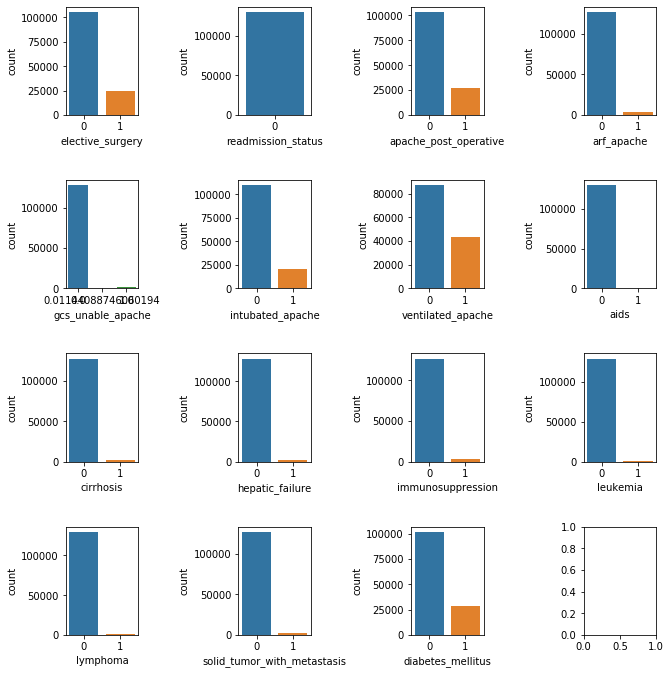

In [ ]:
#exploration of independent binary variables

import matplotlib.pyplot as plt

#  binary_columns = train[['elective_surgery','readmission_status','apache_post_operative','arf_apache','gcs_unable_apache',
#                 'intubated_apache','ventilated_apache','aids','cirrhosis','hepatic_failure','immunosuppression',
#                 'leukemia','lymphoma','solid_tumor_with_metastasis']]

fig, axes = plt.subplots(4,4, figsize = (10,10))
column = 0
row = 0
for i in binary_columns:
    while column < 4:
        sns.countplot(_train[i], ax = axes[column,row])
        row = row + 1
        if row >= 4:
            column = column + 1
            row = 0
        break
fig.tight_layout(pad=3.0)
plt.show()

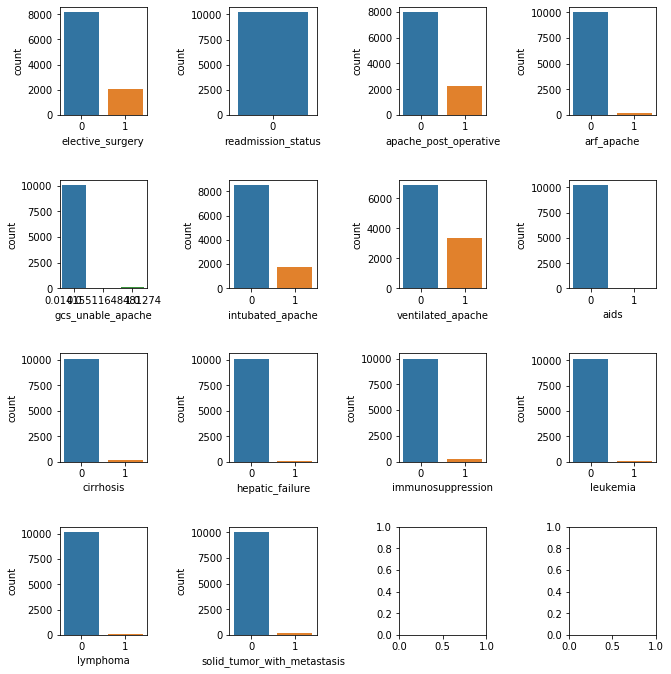

In [ ]:
binary_columns.remove('diabetes_mellitus')
fig, axes = plt.subplots(4,4, figsize = (10,10))
column = 0
row = 0
for i in binary_columns:
    while column < 4:
        sns.countplot(test[i], ax = axes[column,row])
        row = row + 1
        if row >= 4:
            column = column + 1
            row = 0
        break
fig.tight_layout(pad=3.0)
plt.show()

In [ ]:
test['readmission_status'].value_counts()

0    10234
Name: readmission_status, dtype: int64

In [ ]:
_train[binary_columns].dtypes
_train[['gcs_motor_apache']].dtypes

elective_surgery                 int64
readmission_status               int64
apache_post_operative            int64
arf_apache                       int64
gcs_unable_apache              float64
intubated_apache                 int64
ventilated_apache                int64
aids                             int64
cirrhosis                        int64
hepatic_failure                  int64
immunosuppression                int64
leukemia                         int64
lymphoma                         int64
solid_tumor_with_metastasis      int64
dtype: object

gcs_motor_apache    float64
dtype: object

## HANDLING NULL VALUES: Binary Columns (None)

In [ ]:
_train[binary_columns].isnull().sum()

elective_surgery               0
readmission_status             0
apache_post_operative          0
arf_apache                     0
gcs_unable_apache              0
intubated_apache               0
ventilated_apache              0
aids                           0
cirrhosis                      0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
dtype: int64

In [ ]:
test[binary_columns].isnull().sum()

elective_surgery               0
readmission_status             0
apache_post_operative          0
arf_apache                     0
gcs_unable_apache              0
intubated_apache               0
ventilated_apache              0
aids                           0
cirrhosis                      0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
dtype: int64

In [ ]:
# the only variable with missing values is gcs_unable_apache
_train['gcs_unable_apache'].value_counts()

0.000000    127967
1.000000      1481
0.011441       709
Name: gcs_unable_apache, dtype: int64

In [ ]:
data_dictionary.loc[data_dictionary['Variable Name'] == 'gcs_unable_apache','Description']

28    Whether the Glasgow Coma Scale was unable to b...
Name: Description, dtype: object

In [ ]:
# since the frequently appearing class is '1', imputing misisng values in the variable with '1'
_train['gcs_unable_apache'].fillna('1', inplace = True)
test['gcs_unable_apache'].fillna('1', inplace = True)

In [ ]:
#checking for nulls after imputing 
test[binary_columns].isna().sum()
_train[binary_columns].isna().sum()

elective_surgery               0
readmission_status             0
apache_post_operative          0
arf_apache                     0
gcs_unable_apache              0
intubated_apache               0
ventilated_apache              0
aids                           0
cirrhosis                      0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
dtype: int64

elective_surgery               0
readmission_status             0
apache_post_operative          0
arf_apache                     0
gcs_unable_apache              0
intubated_apache               0
ventilated_apache              0
aids                           0
cirrhosis                      0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
dtype: int64

In [ ]:
#dropping columns from train and test that are not valuable based on analysis

#drops 'readmission_status' column has it has no other value than 0
_train.drop('readmission_status', inplace=True, axis=1)
test.drop('readmission_status', inplace=True, axis=1)

In [ ]:
len(binary_columns)

14

### BINARY COLUMNS SUMMARY AND TREATMENT
A total of 14 variables (excluding the target variable)
There was only one column with missing values, 'gcs_unable_apache', imputed the missing values 
with the most frequent value of the column (treated on both _train and test)
Removed the column, 'readmission_status' since the column had only one value in both train and test (treated on both _train and test)

## FINAL CLEAN UP

In [ ]:
# removing values where the age is 0 since it's just 4 rows
_train = _train[_train['age'] > 0]
test = test[test['age'] > 0]
_train.shape
test.shape

(130127, 109)

(10234, 108)

In [ ]:
test.isna().sum()

age                            0
bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
                              ..
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
Length: 108, dtype: int64

## Handling imbalanced classes

<Figure size 1440x1440 with 0 Axes>

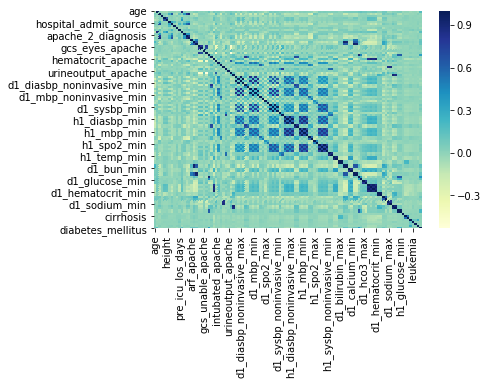

<Figure size 1440x1440 with 0 Axes>

In [ ]:
#correlation before sampling

#studying correlation of independent variables with target
#correlation = train[train.columns[1:]].corr()['diabetes_mellitus'][:]
corr_matrix = _train[_train.columns[:]].corr()
#print(correlation)
sns.heatmap(corr_matrix,cmap='YlGnBu')
plt.figure(figsize=(20,20))
plt.show()

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Balanced Classes')

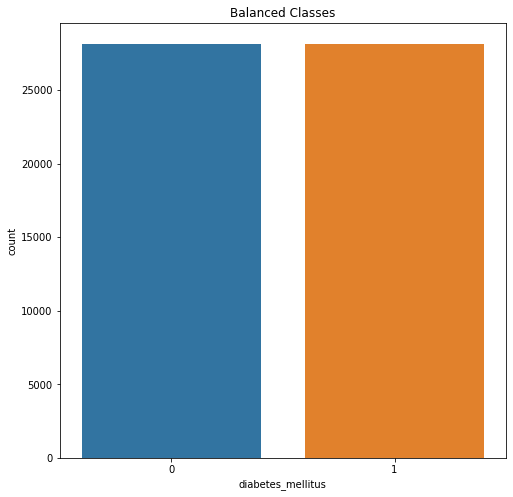

In [ ]:
#undersampling

# shuffled_train = train.sample(frac=1,random_state=4) --- modified to use the right train df

shuffled_train = _train.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
diabetes_train = shuffled_train.loc[shuffled_train['diabetes_mellitus'] == 1]

no_diabetes_train = shuffled_train.loc[shuffled_train['diabetes_mellitus'] == 0].sample(n=28151,random_state=42)

# Concatenate both dataframes again
undersample_train = pd.concat([diabetes_train, no_diabetes_train])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('diabetes_mellitus', data=undersample_train)
plt.title('Balanced Classes')
plt.show()

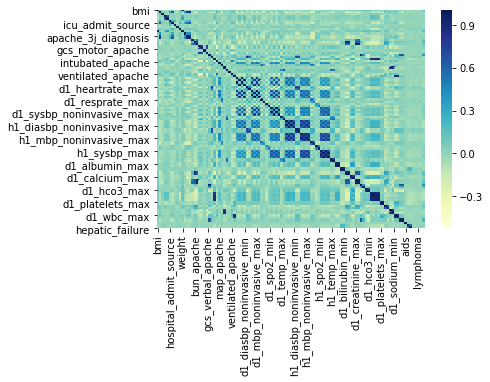

In [ ]:
#correlation after undersampling

#studying correlation of independent variables with target
#correlation = train[train.columns[1:]].corr()['diabetes_mellitus'][:]
corr_matrix = undersample_train[undersample_train.columns[1:]].corr()
#print(correlation)
sns.heatmap(corr_matrix,cmap='YlGnBu')
plt.show()

In [ ]:
_train.shape

(130127, 109)

## Analysing column count (before feature selection):
#### Final usable columns in df `_train = 109 `
- Total columns in train (including target diabetes_mellitus) = 180
- Numeric columns dropped with >60% null values = 67
- Identifier columns dropped = 3
- Binary column dropped = 1 
- Invalid Age (i.e where age==0) rows deleted = 4


## Making validation split

In [ ]:
target = undersample_train.pop('diabetes_mellitus')

In [ ]:
undersample_train.shape
target.shape

(56299, 108)

(56299,)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(undersample_train, target, train_size=0.70)
X_train.shape
X_val.shape
y_train.shape
y_val.shape

(39409, 108)

(16890, 108)

(39409,)

(16890,)

## ML models: trial and error

### Plot ROC function

In [ ]:
# plot roc curve
# source: https://www.kaggle.com/nirajvermafcb/comparing-various-ml-models-roc-curve-comparison/notebook
def plot_roc(name, score, false_positive_rate, true_positive_rate):
  plt.figure(figsize=(10,10))
  plt.title('Receiver Operating Characteristic')
  plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],linestyle='--')
  plt.axis('tight')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title(f'{name}: {score:0.5f}', fontsize=18)
  plt.show()

### Dummy classifier for benchmark

DummyClassifier(constant=None, random_state=None, strategy='stratified')

0.4983318819830691
0.4983318819830691


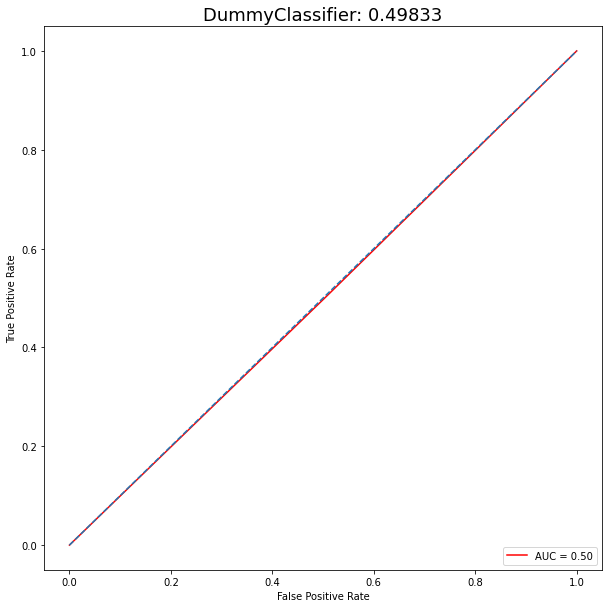

In [ ]:
# Let's get a benchmark : DummyClassifier
model_dummy = DummyClassifier(strategy="stratified")
model_dummy.fit(X_train, y_train)
y_prob = model_dummy.predict_proba(X_val)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
# print(f'{roc_auc_score(y_val, y_prob)}')
print(f'{roc_auc_score(y_val, y_pred)}')

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)
plot_roc('DummyClassifier', roc_auc, false_positive_rate, true_positive_rate)

### Comparing 4 different classifiers

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

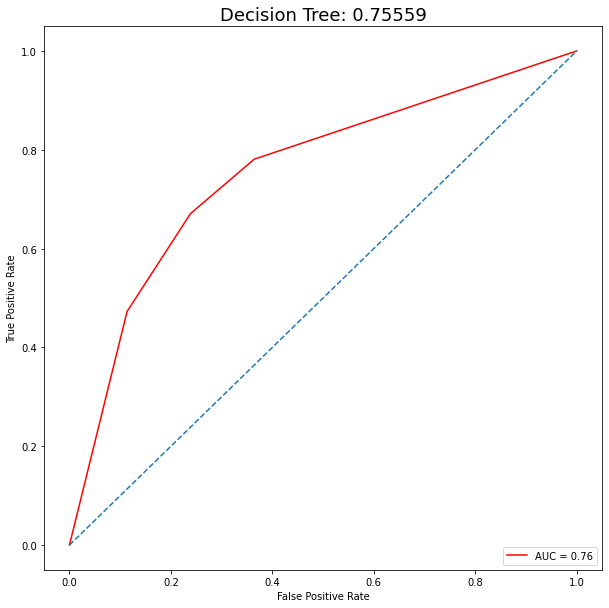

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

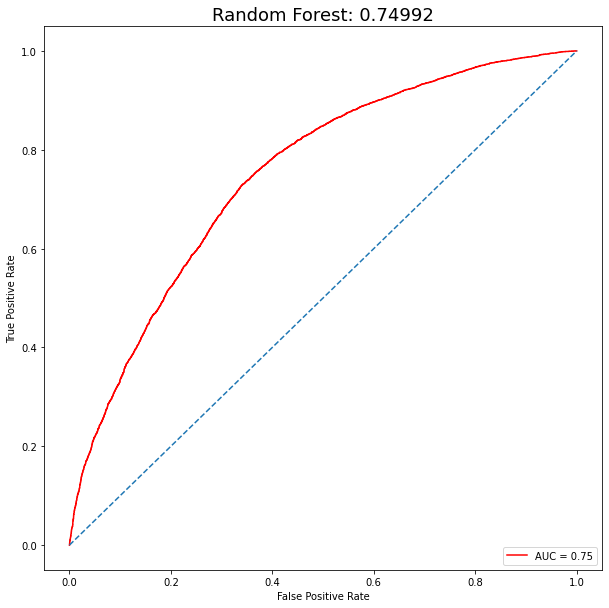

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

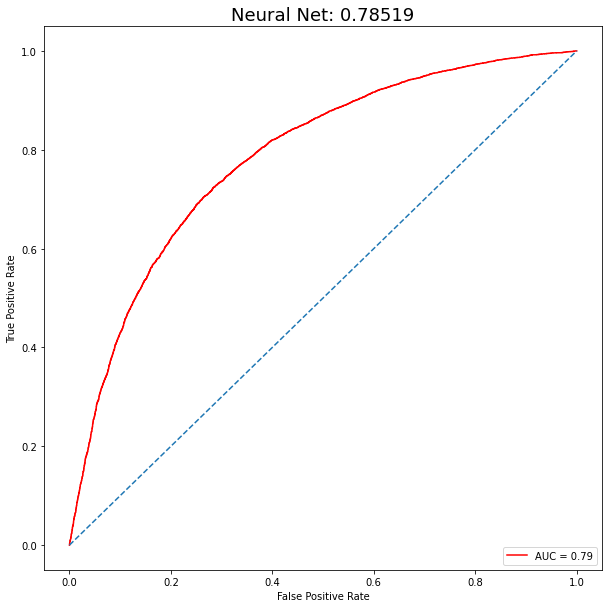

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

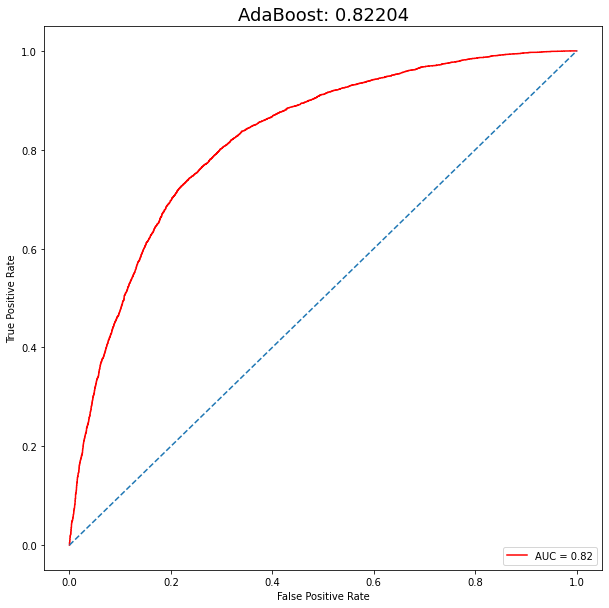

In [ ]:
classifier_names = ["Decision Tree", "Random Forest", "Neural Net", "AdaBoost"]

classifiers = [
    DecisionTreeClassifier(max_depth=2),
    RandomForestClassifier(max_depth=2, n_estimators=100, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier()]

for name, model in zip(classifier_names, classifiers):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_val)[:,1] #  positive class prediction probabilities  
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
    _auc = auc(false_positive_rate, true_positive_rate)
    roc_auc = roc_auc_score(y_val, y_prob)
    # print(roc_auc)
    plot_roc(name, roc_auc, false_positive_rate, true_positive_rate)


In [ ]:
#application of machine learning algorithms for binary classifcation 
RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF.fit(X_train, y_train)
RF.predict(X_val)
print(f'{roc_auc_score(y_val, RF.predict_proba(X_val)[:,1])}')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

array([1, 0, 0, ..., 0, 1, 0])

0.7945049874215362


#### AdaBoost seems to be better with roc_auc 0.822

### AdaBoost for first submission

In [ ]:
test.shape

(10234, 108)

In [ ]:
submissions = pd.read_csv(r'SolutionTemplateWiDS2021.csv')
submissions.head()
submissions.shape
submissions.isna().sum()

,encounter_id,diabetes_mellitus
0,135000,NaN
1,135001,NaN
2,135002,NaN
3,135003,NaN
4,135004,NaN


(10234, 2)

encounter_id             0
diabetes_mellitus    10234
dtype: int64

In [ ]:
test_id.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,...,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,Accident & Emergency,82,admit,Med-Surg ICU,0.015278,0,NaN,2.8,110.0,104.01,0,0,1.9,44.0,1.49,NaN,4.0,6.0,0.0,5.0,97.0,38.0,39.9,0,54.0,NaN,NaN,NaN,NaN,31.0,130.0,...,26.0,14.5,14.5,42.8,42.8,NaN,NaN,NaN,NaN,173.0,173.0,4.9,4.9,132.0,132.0,5.6,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
1,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,Accident & Emergency,82,admit,Med-Surg ICU,0.000000,0,NaN,NaN,117.0,106.01,0,0,NaN,19.0,0.92,NaN,4.0,6.0,0.0,5.0,73.0,116.0,NaN,0,41.0,NaN,NaN,NaN,NaN,53.0,142.0,...,NaN,NaN,NaN,NaN,NaN,2.2,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
2,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,Floor,82,admit,Med-Surg ICU,0.003472,0,NaN,3.2,302.0,109.01,0,0,0.9,24.0,0.77,NaN,4.0,6.0,0.0,5.0,84.0,104.0,34.8,0,117.0,NaN,NaN,NaN,NaN,38.0,137.0,...,32.0,11.8,11.8,36.6,36.6,2.9,2.4,NaN,NaN,243.0,243.0,3.6,3.6,141.0,141.0,6.6,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
3,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,Floor,82,admit,Med-Surg ICU,0.884028,0,NaN,NaN,113.0,501.05,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,4.0,NaN,110.0,NaN,0,61.0,NaN,NaN,NaN,NaN,56.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
4,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,Accident & Emergency,82,admit,Med-Surg ICU,0.013194,0,NaN,3.4,117.0,106.01,0,0,0.4,26.0,1.50,NaN,4.0,6.0,0.0,5.0,99.0,34.0,33.0,0,136.0,NaN,NaN,NaN,NaN,35.0,133.0,...,30.0,10.7,10.7,33.0,33.0,1.1,1.1,NaN,NaN,154.0,154.0,4.0,4.0,133.0,133.0,6.2,6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0


In [ ]:
test_id[test_id['encounter_id']==135000]

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,...,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
370,135000,10055,64,NaN,1,Caucasian,F,157.5,Operating Room,Operating Room / Recovery,92,admit,CTICU,1.063194,0,NaN,NaN,203.0,1206.03,1,0,NaN,13.0,0.65,0.6,4.0,6.0,0.0,5.0,175.0,80.0,25.0,1,56.0,54.0,54.0,137.0,7.21,10.0,143.0,...,NaN,9.2,9.2,28.0,28.0,1.2,1.0,NaN,NaN,82.0,82.0,NaN,NaN,NaN,NaN,13.0,13.0,54.0,39.0,7.33,7.21,500.0,70.0,387.5,200.0,49.0,44.0,7.31,7.28,500.0,122.0,244.0,244.0,0,0,0,0,0,0,0


In [ ]:
test_id =  pd.read_csv(r'UnlabeledWiDS2021.csv', index_col= 'Unnamed: 0')
test_id.shape
test_id['encounter_id'].isna().sum()


(10234, 179)

0

In [ ]:
model = AdaBoostClassifier()
model.fit(undersample_train, target)
y_test_prob = model.predict_proba(test)[:,1] #  positive class prediction probabilities  
print(y_test_prob)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

[0.49403398 0.4992241  0.50183248 ... 0.49774567 0.48787313 0.48671873]


In [ ]:
print(len(y_test_prob))
solution = pd.DataFrame(y_test_prob, columns=['diabetes_mellitus'])
solution
solution.shape

10234


,diabetes_mellitus
0,0.494034
1,0.499224
2,0.501832
3,0.495103
4,0.500718
...,...
10229,0.492896
10230,0.493418
10231,0.497746
10232,0.487873


(10234, 1)

In [ ]:
test_id.reset_index(drop=True, inplace=True)
first_submission = pd.concat([pd.DataFrame(test_id['encounter_id']), solution['diabetes_mellitus']],axis=1)
first_submission

,encounter_id,diabetes_mellitus
0,144740,0.494034
1,141990,0.499224
2,142038,0.501832
3,138628,0.495103
4,141682,0.500718
...,...,...
10229,143750,0.492896
10230,143813,0.493418
10231,137126,0.497746
10232,135652,0.487873


In [ ]:
first_submission.sort_values(by=['encounter_id'], ascending=True, inplace=True)
first_submission.reset_index(drop=True,inplace=True)
first_submission

,encounter_id,diabetes_mellitus
0,135000,0.503218
1,135001,0.488150
2,135002,0.492366
3,135003,0.502467
4,135004,0.483729
...,...,...
10229,145996,0.496408
10230,145997,0.496370
10231,145998,0.499456
10232,145999,0.494946


In [ ]:
first_submission.to_csv('submission.csv', index=False)

## FEATURE SELECTION

In [ ]:
undersample_train.reset_index(drop=True, inplace=True)
undersample_train.head()

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,...,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,83.0,28.124128,1,2,1,167.6,3,0,0,0,0.735417,79.00,202.0,1204.01,1,0,20.0,1.41,4.0,6.0,0.0,4.0,296.0,121.0,32.974794,0,70.0,24.0,136.0,36.50,1585.958400,0,12.188078,99.0,62.0,99.0,62.0,118.0,103.0,109.0,...,124.0,117.0,37.000000,37.000000,2.952551,2.882964,1.191538,1.117545,20.0,20.0,8.100000,8.100000,1.41,1.41,296.0,165.0,21.0,21.0,13.00000,13.000000,36.800000,36.800000,114.000000,114.000000,4.3,4.3,136.0,136.0,26.840000,26.84000,167.702756,158.910129,0,0,0,0,0,0,0,1
1,63.0,30.130162,0,0,1,177.8,3,0,0,5,0.111111,95.25,301.0,403.01,0,0,49.0,5.60,4.0,6.0,0.0,5.0,106.0,96.0,32.300000,0,141.0,48.0,139.0,36.40,1048.464000,0,6.880000,110.0,59.0,110.0,59.0,95.0,73.0,117.0,...,171.0,148.0,36.400000,36.400000,2.952551,2.882964,1.191538,1.117545,49.0,49.0,8.300000,8.300000,5.60,5.60,181.0,106.0,17.0,17.0,10.90000,10.200000,34.400000,32.300000,103.000000,81.000000,5.6,5.6,139.0,139.0,7.330000,6.88000,167.702756,158.910129,0,1,1,0,0,0,0,1
2,76.0,38.181691,0,2,1,158.4,3,0,0,6,0.081944,95.80,121.0,409.02,0,0,14.0,0.77,4.0,6.0,0.0,5.0,202.0,60.0,37.100000,0,125.0,8.0,134.0,36.22,1800.759579,0,8.700000,86.0,45.0,86.0,45.0,66.0,60.0,98.0,...,168.0,168.0,36.660000,36.660000,2.952551,2.882964,1.191538,1.117545,14.0,14.0,8.379858,8.164767,0.77,0.77,202.0,87.0,26.0,26.0,12.80000,12.800000,37.100000,37.100000,289.000000,289.000000,4.1,4.1,134.0,134.0,8.700000,8.70000,167.702756,158.910129,0,0,0,0,0,0,0,1
3,40.0,32.256238,0,2,1,170.2,3,0,0,0,0.140972,93.44,117.0,106.01,0,0,24.0,0.79,4.0,6.0,0.0,5.0,200.0,111.0,43.100000,0,47.0,6.0,139.0,36.30,5799.081600,0,13.420000,92.0,30.0,92.0,30.0,120.0,71.0,97.0,...,119.0,104.0,36.800000,36.800000,4.100000,4.100000,0.600000,0.600000,24.0,24.0,9.000000,9.000000,0.79,0.79,200.0,134.0,28.0,28.0,14.50000,14.500000,43.100000,43.100000,218.000000,218.000000,4.1,4.1,139.0,139.0,13.420000,13.42000,167.702756,158.910129,0,0,0,1,0,0,0,1
4,72.0,61.093750,0,0,0,160.0,2,0,0,0,1.618750,156.40,110.0,104.01,0,0,62.0,3.60,4.0,6.0,0.0,5.0,193.0,127.0,32.974794,0,113.0,30.0,135.0,36.40,1800.759579,1,12.188078,91.0,56.0,91.0,56.0,123.0,78.0,102.0,...,161.0,155.0,36.722697,36.614082,3.200000,3.200000,1.191538,1.117545,62.0,62.0,9.300000,9.300000,3.60,3.60,193.0,167.0,24.0,24.0,11.45956,10.901227,34.554963,32.938273,205.892503,194.917161,5.0,5.0,135.0,135.0,12.540132,11.29905,167.000000,167.000000,0,0,0,0,0,0,0,1


In [ ]:
array = undersample_train.values
X = array[:,0:108]
Y = array[:,108]

In [ ]:
X.shape
Y.shape

(56296, 108)

(56296,)

## Feature Importance

### LINEAR REGRESSION FEATURE IMPORTANCE

In [ ]:
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
model= LinearRegression()

LinearRegression()

Feature: 0, Score: 0.00327
Feature: 1, Score: 0.00362
Feature: 2, Score: 0.03682
Feature: 3, Score: 0.02124
Feature: 4, Score: -0.02857
Feature: 5, Score: -0.00116
Feature: 6, Score: 0.00057
Feature: 7, Score: -0.01681
Feature: 8, Score: -0.00473
Feature: 9, Score: 0.00182
Feature: 10, Score: 0.00154
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00233
Feature: 13, Score: 0.00010
Feature: 14, Score: -0.00002
Feature: 15, Score: 0.00359
Feature: 16, Score: 0.19044
Feature: 17, Score: 0.00012
Feature: 18, Score: 0.00140
Feature: 19, Score: 0.01262
Feature: 20, Score: 0.00678
Feature: 21, Score: -0.05326
Feature: 22, Score: -0.00093
Feature: 23, Score: -0.00047
Feature: 24, Score: 0.00011
Feature: 25, Score: -0.00059
Feature: 26, Score: -0.01456
Feature: 27, Score: -0.00011
Feature: 28, Score: -0.00050
Feature: 29, Score: 0.00223
Feature: 30, Score: 0.00254
Feature: 31, Score: 0.00001
Feature: 32, Score: 0.00489
Feature: 33, Score: 0.00013
Feature: 34, Score: -0.00020
Feature: 35, Scor

<BarContainer object of 109 artists>

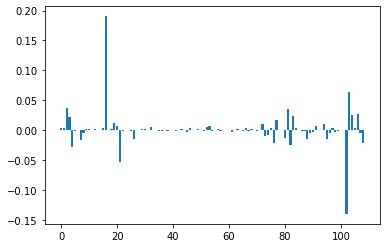

In [ ]:
model.fit(X,Y)
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### LOGISTICS REGRESSION FEATURE IMPORTANCE ** needs to fix***

In [ ]:
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
array = undersample_train.values
X = array[:,0:109]
Y = array[:,109]
model2  = LogisticRegression()
model2.fit(X,Y)
importance2 = model2.coef_
for i,v in enumerate(importance2):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance2))], importance2)
pyplot.show()


ValueError: Unknown label type: 'unknown'

### DECISION TREE  ** Looks like the best option to use **

DecisionTreeRegressor()

Feature: 0, Score: 0.02505
Feature: 1, Score: 0.03686
Feature: 2, Score: 0.00050
Feature: 3, Score: 0.00473
Feature: 4, Score: 0.00114
Feature: 5, Score: 0.01014
Feature: 6, Score: 0.00385
Feature: 7, Score: 0.00248
Feature: 8, Score: 0.00118
Feature: 9, Score: 0.00435
Feature: 10, Score: 0.01226
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.01487
Feature: 13, Score: 0.01095
Feature: 14, Score: 0.01232
Feature: 15, Score: 0.00011
Feature: 16, Score: 0.00258
Feature: 17, Score: 0.00626
Feature: 18, Score: 0.00812
Feature: 19, Score: 0.00228
Feature: 20, Score: 0.00510
Feature: 21, Score: 0.00097
Feature: 22, Score: 0.00302
Feature: 23, Score: 0.01736
Feature: 24, Score: 0.01194
Feature: 25, Score: 0.00814
Feature: 26, Score: 0.00128
Feature: 27, Score: 0.00753
Feature: 28, Score: 0.00898
Feature: 29, Score: 0.00374
Feature: 30, Score: 0.00825
Feature: 31, Score: 0.00910
Feature: 32, Score: 0.00318
Feature: 33, Score: 0.00748
Feature: 34, Score: 0.00526
Feature: 35, Score: 0.00503
Fe

<BarContainer object of 109 artists>

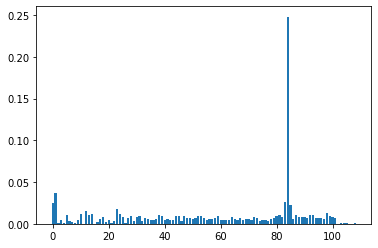

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
array = undersample_train.values
X = array[:,0:109]
Y = array[:,109]
model3 = DecisionTreeRegressor()
# fit the model
model3.fit(X, Y)
# get importance
importance3 = model3.feature_importances_
# summarize feature importance
for i,v in enumerate(importance3):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance3))], importance3)
pyplot.show()

### USING GBOOST

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


[00:06:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Feature: 0, Score: 0.02085
Feature: 1, Score: 0.02298
Feature: 2, Score: 0.00563
Feature: 3, Score: 0.01793
Feature: 4, Score: 0.00453
Feature: 5, Score: 0.00605
Feature: 6, Score: 0.00553
Feature: 7, Score: 0.00772
Feature: 8, Score: 0.00534
Feature: 9, Score: 0.00704
Feature: 10, Score: 0.00684
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.01050
Feature: 13, Score: 0.00989
Feature: 14, Score: 0.00873
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.03130
Feature: 17, Score: 0.00697
Feature: 18, Score: 0.00617
Feature: 19, Score: 0.01034
Feature: 20, Score: 0.01687
Feature: 21, Score: 0.01085
Feature: 22, Score: 0.00683
Feature: 23, Score: 0.01628
Feature: 24, Score: 0.00779
Feature: 25, Score: 0.00572
Feature: 26, Score: 0.02084
Feature: 27, Score: 0.00580
Feature: 28, Score: 0.00562
Feature: 29, Score: 0.00562
Feature: 30, Score: 0.00681
Feature: 31, Score: 0.00746
Feature: 32, Score: 0.03021
Feature: 33, Score: 0.00856
Feature: 34, Score: 0.00603
Feature: 35, Score: 0.00536
Fe

<BarContainer object of 109 artists>

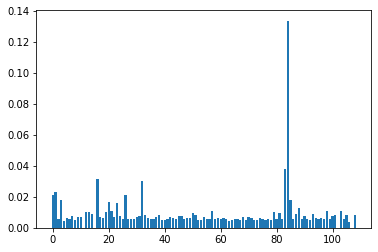

In [ ]:
# xgboost for feature importance on a classification problem
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from matplotlib import pyplot
array = undersample_train.values
X = array[:,0:109]
Y = array[:,109]
# define the model
model = XGBClassifier()
# fit the model
model.fit(X, Y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
Y.shape

(55637,)

### Using Recursive Feature Elimination

In [ ]:
pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in c:\programdata\anaconda3\lib\site-packages (0.24.1)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
array = undersample_train.values
X = array[:,0:109]
Y = array[:,109]
# permutation feature importance with knn for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define the model
model = KNeighborsClassifier()
# fit the model
model.fit(X, Y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()



ValueError: Unknown label type: 'unknown'